Right now you show histograms and proportions of strengthened edges.
    1.  Canonical network analysis
        - Assign ROIs to DMN, salience, limbic, FPN, etc.
        - For each network:
            - sgACC-to-network FC change (active vs sham, during & post).
            - Ask: is sgACC preferentially integrating into limbic/DMN/affective control circuits vs everything?
    2.  Graph-theoretic metrics
        - Compute, for sgACC:
            - degree/strength, participation coefficient, within- vs between-network connectivity, eigenvector centrality.
            - Pre vs during vs post, active vs sham.
        - Show sgACC becomes more integrative hub-like after tFUS (or more embedded in specific networks).
    3.  Network-Based Statistic (NBS) or FDR-controlled edgewise maps
        - Identify a connected subnetwork of edges significantly modulated by active vs sham.
        - Visualize as a network centered on sgACC, not just a bar.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nibabel as nib
from nilearn import input_data, datasets, plotting, signal
from scipy import stats
import statsmodels.formula.api as smf

from statsmodels.stats.multitest import multipletests

In [2]:
## Load the precomputed dataframe
path_to_df = '../data/precomputed/df_fc.pkl'
df = pd.read_pickle(path_to_df)

In [3]:
difumo = datasets.fetch_atlas_difumo(dimension=1024)
df_labels = pd.DataFrame(difumo.labels)  # List of 1024 anatomical labels
#atlas_img = nib.load(difumo.maps)
subgenual = df_labels.loc[133,'difumo_names']
df_labels.head()

,component,difumo_names,yeo_networks7,yeo_networks17,gm,wm,csf
0,1,Retrocalcarine cortex RH,VisCent,VisCent,0.448141,0.536476,0.015397
1,2,Superior longitudinal fasciculus II mid-poster...,No network found,No network found,0.017326,0.982661,0.000024
2,3,Arcuate fasciculus mid-anterior RH,DorsAttnB,ContA,0.502915,0.473717,0.023376
3,4,Cerebrospinal fluid (between middle frontal gy...,ContA,SalVentAttnB,0.400989,0.023640,0.125466
4,5,Precentral sulcus mid-inferior RH,DorsAttnB,ContA,0.668818,0.199817,0.120609


In [4]:
df_labels["yeo_networks7"].unique()
yeo_map = {roi : network for roi, network in zip(df_labels["difumo_names"], df_labels["yeo_networks7"])}


In [5]:
df["is_roi1_subgenual"] = df["roi1"] == subgenual
df["is_roi2_subgenual"] = df["roi2"] == subgenual
df["is_pair_subgenual"] = df["is_roi1_subgenual"] | df["is_roi2_subgenual"]
df_sg = df[df["is_pair_subgenual"]].copy()
df_sg["roi_pair"] = ["__".join(sorted((r1, r2))) for r1, r2 in zip(df_sg["roi1"], df_sg["roi2"])]
#dfw = df_sg.copy().drop(columns=["roi1", "roi2", "is_roi1_subgenual", "is_roi2_subgenual", "is_pair_subgenual","roi_pair"]).reset_index(drop=True)

In [6]:
df_sg["network1"] = df_sg["roi1"].map(yeo_map)
df_sg["network2"] = df_sg["roi2"].map(yeo_map)
df_sg["network_pair"] = ["__".join(sorted((n1, n2))) for n1, n2 in zip(df_sg["network1"], df_sg["network2"])
]

# remove entries without a Yeo-7 assignment for either ROI
df_sg = df_sg[~df_sg["network_pair"].str.contains("No network found", na=False)].copy()

def _extract_partner_network(pair):
    tokens = pair.split("__")
    partners = [token for token in tokens if not token.startswith("Limbic")]
    if not partners:
        partners = [tokens[0]]
    return partners[0]

network_label_map = {
    "Vis": "Visual",
    "Cont": "Control",
    "Default": "Default Mode",
    "DorsAttn": "Dorsal Attention",
    "Limbic": "Limbic",
    "SalVentAttn": "Salience",
    "SomMot": "Somatomotor",
}

def _format_network_label(network_code):
    if network_code is None:
        return None
    base = network_code.rstrip("AB")
    if base.startswith("Vis"):
        base = "Vis"
    return network_label_map.get(base, base)

df_sg["network_partner"] = df_sg["network_pair"].apply(_extract_partner_network)
df_sg["network_label"] = df_sg["network_partner"].apply(_format_network_label)
allowed_networks = list(network_label_map.values())
df_sg = df_sg[df_sg["network_label"].isin(allowed_networks)].copy()
df_sg.head()


,fc,roi1,roi2,subject,time_window,condition,is_roi1_subgenual,is_roi2_subgenual,is_pair_subgenual,roi_pair,network1,network2,network_pair,network_partner,network_label
132,-0.123240,Retrocalcarine cortex RH,Subgenual cortex,0,pre,active,False,True,True,Retrocalcarine cortex RH__Subgenual cortex,VisCent,LimbicA,LimbicA__VisCent,VisCent,Visual
2175,-0.068318,Arcuate fasciculus mid-anterior RH,Subgenual cortex,0,pre,active,False,True,True,Arcuate fasciculus mid-anterior RH__Subgenual ...,DorsAttnB,LimbicA,DorsAttnB__LimbicA,DorsAttnB,Dorsal Attention
3195,-0.306134,Cerebrospinal fluid (between middle frontal gy...,Subgenual cortex,0,pre,active,False,True,True,Cerebrospinal fluid (between middle frontal gy...,ContA,LimbicA,ContA__LimbicA,ContA,Control
4214,-0.292831,Precentral sulcus mid-inferior RH,Subgenual cortex,0,pre,active,False,True,True,Precentral sulcus mid-inferior RH__Subgenual c...,DorsAttnB,LimbicA,DorsAttnB__LimbicA,DorsAttnB,Dorsal Attention
6249,-0.083583,Paracingulate gyrus posterior,Subgenual cortex,0,pre,active,False,True,True,Paracingulate gyrus posterior__Subgenual cortex,SalVentAttnA,LimbicA,LimbicA__SalVentAttnA,SalVentAttnA,Salience


In [7]:
dfw = df_sg.copy().drop(columns=["roi1", "roi2", "is_roi1_subgenual", "is_roi2_subgenual", "is_pair_subgenual",
                                  "roi_pair", "network1", "network2"]).reset_index(drop=True)

# baseline at the subject × (sgACC-network) × condition level
dfw["subject_network_condition"] = list(zip(dfw["subject"], dfw["network_pair"], dfw["condition"]))
baseline_lookup = (
    dfw[dfw["time_window"] == "pre"]
    .set_index("subject_network_condition")["fc"]
    .to_dict()
)

dfw["baseline_fc"] = dfw["subject_network_condition"].map(baseline_lookup)
dfw = dfw.dropna(subset=["baseline_fc"]).reset_index(drop=True)
dfw["delta_fc"] = dfw["fc"] - dfw["baseline_fc"]
dfw.drop(columns=["subject_network_condition"], inplace=True)
dfw.head()


,fc,subject,time_window,condition,network_pair,network_partner,network_label,baseline_fc,delta_fc
0,-0.123240,0,pre,active,LimbicA__VisCent,VisCent,Visual,0.097183,-0.220424
1,-0.068318,0,pre,active,DorsAttnB__LimbicA,DorsAttnB,Dorsal Attention,0.090965,-0.159283
2,-0.306134,0,pre,active,ContA__LimbicA,ContA,Control,-0.315298,0.009164
3,-0.292831,0,pre,active,DorsAttnB__LimbicA,DorsAttnB,Dorsal Attention,0.090965,-0.383796
4,-0.083583,0,pre,active,LimbicA__SalVentAttnA,SalVentAttnA,Salience,-0.189846,0.106263


In [ ]:
df_delta = dfw[dfw["time_window"] != "pre"].copy()
#df_delta = dfw.copy()
group_cols = ["subject", "condition", "time_window", "network_label"]
df_subject_delta = (
    df_delta
    .groupby(group_cols, as_index=False)["delta_fc"]
    .mean()
)
df_subject_delta


,subject,condition,time_window,network_label,delta_fc
0,0,active,fus,Control,0.213067
1,0,active,fus,Default Mode,0.001633
2,0,active,fus,Dorsal Attention,-0.104177
3,0,active,fus,Limbic,-0.043093
4,0,active,fus,Salience,0.089163
...,...,...,...,...,...
667,15,sham,pre,Dorsal Attention,0.230781
668,15,sham,pre,Limbic,-0.073375
669,15,sham,pre,Salience,-0.086938
670,15,sham,pre,Somatomotor,0.160949


In [95]:
time_order = ["fus", "post"]
network_order = ["Visual", "Control", "Default Mode", "Dorsal Attention", "Limbic", "Salience", "Somatomotor"]

df_subject_delta["time_window"] = pd.Categorical(
    df_subject_delta["time_window"],
    categories=time_order,
    ordered=True
)

df_subject_delta["network_label"] = pd.Categorical(
    df_subject_delta["network_label"],
    categories=network_order,
    ordered=True
)

dfr = (
    df_subject_delta
    .groupby(["network_label", "condition", "time_window"], as_index=False)["delta_fc"]
    .mean()
)
dfr.head()


/var/folders/g9/8jw7l6116kdd4pc549qnnz8r0000gn/T/ipykernel_49748/3472111985.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["network_label", "condition", "time_window"], as_index=False)["delta_fc"]


,network_label,condition,time_window,delta_fc
0,Visual,active,fus,0.015969
1,Visual,active,post,0.044104
2,Visual,sham,fus,-0.026088
3,Visual,sham,post,-0.027297
4,Control,active,fus,0.075409


In [96]:
test_records = []

for network in network_order:
    for time_window in time_order:
        sham_vals = df_subject_delta[
            (df_subject_delta["condition"] == "sham")
            & (df_subject_delta["network_label"] == network)
            & (df_subject_delta["time_window"] == time_window)
        ]["delta_fc"].dropna()

        active_vals = df_subject_delta[
            (df_subject_delta["condition"] == "active")
            & (df_subject_delta["network_label"] == network)
            & (df_subject_delta["time_window"] == time_window)
        ]["delta_fc"].dropna()

        if len(sham_vals) < 2 or len(active_vals) < 2:
            t_stat, p_val = float('nan'), float('nan')
        else:
            t_stat, p_val = stats.ttest_ind(active_vals, sham_vals, equal_var=False)

        test_records.append({
            "network": network,
            "time_window": time_window,
            "n_sham": len(sham_vals),
            "n_active": len(active_vals),
            "t_stat": t_stat,
            "p_value": p_val,
        })

test_df = pd.DataFrame(test_records)
mask = test_df["p_value"].notna()
if mask.any():
    _, p_fdr, _, _ = multipletests(test_df.loc[mask, "p_value"], method="fdr_bh")
    test_df.loc[mask, "p_fdr"] = p_fdr
test_df


,network,time_window,n_sham,n_active,t_stat,p_value,p_fdr
0,Visual,fus,16,16,0.884897,0.383464,0.412961
1,Visual,post,16,16,1.129649,0.268281,0.391094
2,Control,fus,16,16,3.138121,0.003863,0.053756
3,Control,post,16,16,2.859207,0.007679,0.053756
4,Default Mode,fus,16,16,-0.960271,0.344975,0.402471
5,Default Mode,post,16,16,-0.722027,0.476145,0.476145
6,Dorsal Attention,fus,16,16,1.035690,0.309274,0.393621
7,Dorsal Attention,post,16,16,1.103115,0.279353,0.391094
8,Limbic,fus,16,16,1.345189,0.189179,0.331062
9,Limbic,post,16,16,1.444667,0.159998,0.331062


/var/folders/g9/8jw7l6116kdd4pc549qnnz8r0000gn/T/ipykernel_49748/1859640273.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["tFUS", "Post"])
/var/folders/g9/8jw7l6116kdd4pc549qnnz8r0000gn/T/ipykernel_49748/1859640273.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["tFUS", "Post"])
/var/folders/g9/8jw7l6116kdd4pc549qnnz8r0000gn/T/ipykernel_49748/1859640273.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["network_label", "time_window", "condition"], as_index=False)["delta_fc"]
/var/folders/g9/8jw7l6116kdd4pc549qnnz8r0000gn/T/ipykernel_49748/1859640273.py:68: FutureWarnin

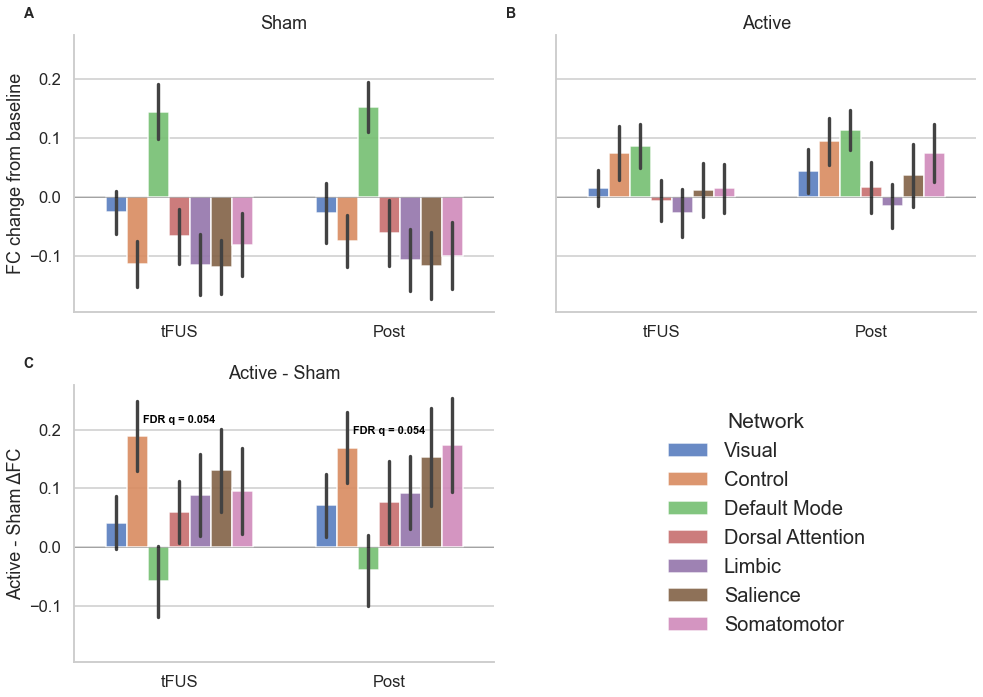

In [101]:
sns.set_theme(style="whitegrid", context="talk")
palette = dict(zip(
    network_order,
    sns.color_palette("muted", len(network_order))
))

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)
panel_map = {
    'sham': axes[0, 0],
    'active': axes[0, 1],
    'diff': axes[1, 0],
    'legend': axes[1, 1],
}
panel_info = [(panel_map['sham'], "sham", "Sham", "A"), (panel_map['active'], "active", "Active", "B")]

for ax, condition, title, panel_label in panel_info:
    data_cond = df_subject_delta[df_subject_delta["condition"] == condition]

    sns.barplot(
        data=data_cond,
        x="time_window",
        y="delta_fc",
        hue="network_label",
        order=time_order,
        hue_order=network_order,
        palette=palette,
        ax=ax,
        alpha=0.9,
        width=0.7,
        errorbar="se",
        estimator=np.mean,
    )

    legend = ax.get_legend()
    if legend is not None:
        legend.remove()

    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_xticklabels(["tFUS", "Post"])
    sns.despine(ax=ax)
    ax.axhline(0, color="black", linewidth=0.8, alpha=0.3)

    if ax is panel_map['sham']:
        ax.set_ylabel("FC change from baseline")
    else:
        ax.set_ylabel("")

    ax.text(
        -0.12,
        1.05,
        panel_label,
        transform=ax.transAxes,
        ha="left",
        va="bottom",
        fontsize=14,
        fontweight="bold",
    )

mean_by_condition = (
    df_subject_delta
    .groupby(["network_label", "time_window", "condition"], as_index=False)["delta_fc"]
    .mean()
)

subject_diff = (
    df_subject_delta
    .pivot_table(index=["subject", "network_label", "time_window"], columns="condition", values="delta_fc")
    .dropna()
    .reset_index()
)
subject_diff["diff"] = subject_diff["active"] - subject_diff["sham"]
subject_diff["time_window"] = pd.Categorical(
    subject_diff["time_window"],
    categories=time_order,
    ordered=True
)
subject_diff["network_label"] = pd.Categorical(
    subject_diff["network_label"],
    categories=network_order,
    ordered=True
)

diff_summary = (
    subject_diff
    .groupby(["network_label", "time_window"], as_index=False)["diff"]
    .mean()
)

ax = panel_map['diff']
sns.barplot(
    data=subject_diff,
    x="time_window",
    y="diff",
    hue="network_label",
    order=time_order,
    hue_order=network_order,
    palette=palette,
    ax=ax,
    alpha=0.9,
    width=0.7,
    errorbar="se",
    estimator=np.mean,
)

legend = ax.get_legend()
handles, labels = ax.get_legend_handles_labels()
if legend is not None:
    legend.remove()

ax.set_title("Active - Sham")
ax.set_xlabel("")
ax.set_xticklabels(["tFUS", "Post"])
ax.set_ylabel("Active - Sham ΔFC")
sns.despine(ax=ax)
ax.axhline(0, color="black", linewidth=0.8, alpha=0.3)
ax.text(
    -0.12,
    1.05,
    "C",
    transform=ax.transAxes,
    ha="left",
    va="bottom",
    fontsize=14,
    fontweight="bold",
)

control_q = {}
if 'test_df' in globals():
    control_q = (
        test_df[test_df["network"] == "Control"]
        .set_index("time_window")["p_fdr"]
        .to_dict()
    )

control_rows = diff_summary[diff_summary["network_label"] == "Control"]
for _, row in control_rows.iterrows():
    xpos = time_order.index(row["time_window"])
    ypos = row["diff"]
    offset = 0.02 if ypos >= 0 else -0.02
    va = "bottom" if ypos >= 0 else "top"
    q_val = control_q.get(row["time_window"])
    if q_val is None or np.isnan(q_val):
        label = "FDR q n/a"
    elif q_val < 0.05:
        label = "FDR q < 0.05"
    else:
        label = f"FDR q = {q_val:.3f}"
    ax.text(
        xpos,
        ypos + offset,
        label,
        ha="center",
        va=va,
        fontsize=11,
        fontweight="bold",
        color="black"
    )

legend_ax = panel_map['legend']
legend_ax.axis('off')
legend_ax.legend(
    handles[:len(network_order)],
    labels[:len(network_order)],
    title="Network",
    frameon=False,
    loc="center",
    fontsize=20,
    title_fontsize=21
)

plt.tight_layout()
plt.show()


In [98]:
dfr.head(20)


,network_label,condition,time_window,delta_fc
0,Visual,active,fus,0.015969
1,Visual,active,post,0.044104
2,Visual,sham,fus,-0.026088
3,Visual,sham,post,-0.027297
4,Control,active,fus,0.075409
5,Control,active,post,0.094716
6,Control,sham,fus,-0.113081
7,Control,sham,post,-0.074511
8,Default Mode,active,fus,0.087331
9,Default Mode,active,post,0.114280
